## 4a. Putting It All Together

With our classifier completed, we are able to predict the piece on each individual square. To get the full position, it's just a matter of combining these predictions. The code below converts an array of predicted labels into a FEN.

In [1]:
def encode_fen(labels):
    fen = ""
    n_empty = 0
    for i in range(64):
        if labels[i] == "_":
            n_empty += 1
            if i % 8 == 7 or labels[i+1] != "_":
                fen += str(n_empty)
                n_empty = 0
        else:
            fen += labels[i]
        if i % 8 == 7 and i < 63:
            fen += "/"
    return fen

Next, we load the model that we trained in model.ipynb.

In [2]:
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")

And finally we're ready to put everything together:

In [3]:
from PIL import Image
import numpy as np
from comp_vision import split_image

def generate_position(img, black_pov=False, black_to_play=False):
    img = img.convert('L')
    squares = split_image(img)
    if not squares:
        return "Failed to detect chessboard corners"
    squares = np.array([np.array(s).reshape(32,32,1) for s in squares])
    squares = squares/255.
    int_labels = model.predict(squares).argmax(axis=-1)
    piece_names = ['P','N','B','R','Q','K','p','n','b','r','q','k','_']
    str_labels = [piece_names[i] for i in int_labels]
    if black_pov:  # Reverse pieces for black's point of view
        str_labels = str_labels[::-1]
    fen = encode_fen(str_labels)
    position = "https://lichess.org/editor/{}_{}".format(fen, 'b' if black_to_play else 'w')
    return position

## 4b. Some Examples

Let's test our algorithm on a couple examples. We'll start with our example from the very beginning.

In [4]:
def rescale(img, desired_height:int):
    width, height = img.size[:2]
    scale = desired_height/height
    return img.resize((int(width*scale),desired_height))

def analyze(img_path, black_pov=False, black_to_play=False):
    img = Image.open(img_path)
    print("INPUT IMAGE:")
    display(rescale(img,300))
    print("PREDICTED POSITION:")
    display(generate_position(img, black_pov, black_to_play))

INPUT IMAGE:


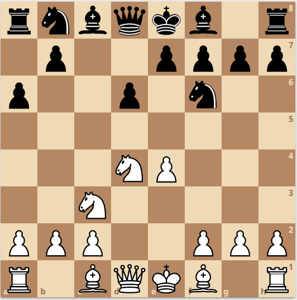

PREDICTED POSITION:


'https://lichess.org/editor/rnbqkb1r/1p2pppp/p2p1n2/8/3NP3/2N5/PPP2PPP/R1BQKB1R_w'

In [5]:
analyze("images/example_board.png")

INPUT IMAGE:


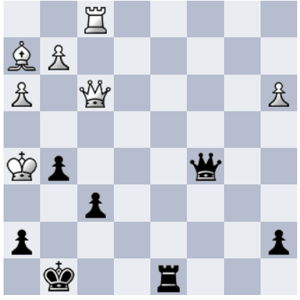

PREDICTED POSITION:


'https://lichess.org/editor/2R5/BP6/P1Q4P/8/Kp3q2/2p5/p6p/1k2r3_w'

In [6]:
analyze("images/puzzle.png")

INPUT IMAGE:


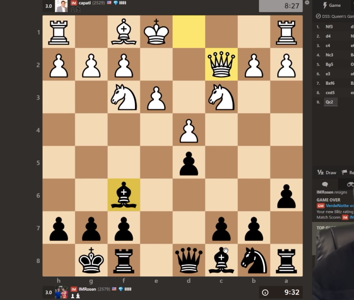

PREDICTED POSITION:


'https://lichess.org/editor/rnbq1rk1/1pp2ppp/p4b2/3p4/3P4/2N1PN2/PPQ2PPP/R3KB1R_b'

In [7]:
analyze("images/youtube.png", black_pov=True, black_to_play=True)

INPUT IMAGE:


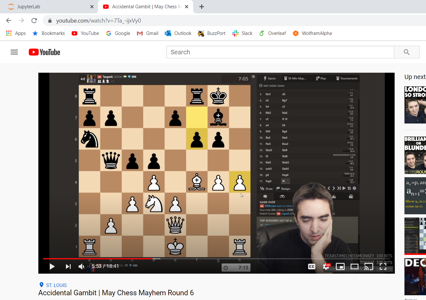

PREDICTED POSITION:


'https://lichess.org/editor/r4rk1/pp2p1b1/n4pp1/1qpp4/3P1BPP/2PNP3/1P2Q3/R3K2R_w'

In [8]:
analyze("images/youtube_big.png")